#### **Course Rating Prediction using Neural Networks**


##### **tf.keras.layers.Embedding**
- Turns positive integers (indexes) into dense vectors of fixed size.

**Resource** : https://www.kaggle.com/code/colinmorris/embedding-layers

In [ ]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.layers import (
    Dense,
    Embedding,
    Input,
    Dropout,
    Dot
)

from keras.models import Model

In [2]:
def load_ratings():
    return pd.read_csv('ratings.csv')

In [3]:
rating_df = load_ratings()
rating_df.head()

,user,item,rating
0,1889878,CC0101EN,3.0
1,1342067,CL0101EN,3.0
2,1990814,ML0120ENv3,3.0
3,380098,BD0211EN,3.0
4,779563,DS0101EN,3.0


In [4]:
num_users = len(rating_df['user'].unique())
num_items = len(rating_df['item'].unique())
print(f"There are total `{num_users}` of users and `{num_items}` items")

There are total `33901` of users and `126` items


#### Implementing the recommender neural network using tensorflow


In [5]:
def emb_create(n_user, n_item, n_user_latent_dim: int = 16, n_item_latent_dim: int = 16, reg_users: int = 1e-6, reg_items: int = 1e-6) -> keras.Model:

    user_input = Input(shape=(), dtype='int32', name='user')
    item_input = Input(shape=(), dtype='int32', name='item')

    # USER
    user_embedding = Embedding(input_dim=n_user,
                    output_dim=n_user_latent_dim,
                    name='user_embedding',
                    embeddings_initializer="he_normal",
                    embeddings_regularizer=keras.regularizers.l2(reg_users)
                    )(user_input)

    # ITEM
    item_embedding = Embedding(input_dim=n_item,
                    output_dim=n_item_latent_dim,
                    name='item_embedding',
                    embeddings_initializer="he_normal",
                    embeddings_regularizer=keras.regularizers.l2(reg_items)
                    )(item_input)

    merged = Dot(name='dot', normalize=True, axes=1)([user_embedding, item_embedding])
    merged_dropout = Dropout(0.2)(merged)

    #hidden layers
    dense_1 = Dense(units=64, name='Dense_1')(merged_dropout)
    do_1 = Dropout(0.2, name='Dropout_1')(dense_1)

    dense_2 = Dense(units=32, name='Dense_2')(do_1)
    do_2 = Dropout(0.2, name='Dropout_2')(dense_2)

    dense_3 = Dense(units=16, name='Dense_3')(do_2)
    do_3 = Dropout(0.2, name='Dropout_3')(dense_3)

    dense_4 = Dense(units=8, name='Dense_4')(do_3)

    result = Dense(1, name='rating', activation='relu')(dense_4)

    model = Model(inputs=[user_input, item_input], outputs=[result])
    model._name = 'embedding_extraction_model'
    
    return model

The embedding matrix is updated using `gradient descent` + `backpropagation` just like any other layer in a neural network.

In [6]:
def emb_data_prep(raw_data):
    
    encoded_data = raw_data.copy()

    user_id2idx = {x: i for i, x in enumerate(encoded_data["user"].unique())}
    item_id2idx = {x: i for i, x in enumerate(encoded_data["item"].unique())}

    encoded_data['user'] = encoded_data['user'].map(user_id2idx)
    encoded_data['item'] = encoded_data['item'].map(item_id2idx)

    return encoded_data, user_id2idx, item_id2idx

In [7]:
encoded_data, user_id2idx, course_id2idx = emb_data_prep(rating_df)

In [8]:
def emb_ds_create(df, val_split = 0.1, batch_size = 512, rs = 42):
    
    if rs: 
        df = df.sample(frac=1, random_state=rs).reset_index(drop=True)

    n_val = round(len(df) * val_split)

    x = {
        'user': df['user'].values,
        'item': df['item'].values
    }
    y = df['rating'].values

    ds = tf.data.Dataset.from_tensor_slices((x, y))

    ds_val = ds.take(n_val).batch(batch_size)
    ds_train = ds.skip(n_val).batch(batch_size)
    
    return ds_train, ds_val

In [9]:
ds_train, ds_val = emb_ds_create(encoded_data)

In [10]:
def emb_train(ds_train, ds_val, epochs = 10, embedding_size = 16):

    df = load_ratings()
    num_users = len(df['user'].unique())
    num_items = len(df['item'].unique())

    emb_model = emb_create(n_user=num_users, n_item=num_items, n_item_latent_dim=embedding_size, n_user_latent_dim=embedding_size)
    emb_model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(), metrics=[tf.keras.metrics.MeanSquaredError()])
    emb_model_hist = emb_model.fit(x = ds_train, validation_data = ds_val, epochs=epochs, verbose=1)

    return emb_model, emb_model_hist

In [11]:
emb, emb_hist = emb_train(ds_train=ds_train, ds_val=ds_val)

Epoch 1/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 1.6804 - mean_squared_error: 1.6804 - val_loss: 0.0512 - val_mean_squared_error: 0.0511
Epoch 2/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.1617 - mean_squared_error: 0.1616 - val_loss: 0.0440 - val_mean_squared_error: 0.0439
Epoch 3/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0991 - mean_squared_error: 0.0989 - val_loss: 0.0443 - val_mean_squared_error: 0.0441
Epoch 4/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0686 - mean_squared_error: 0.0684 - val_loss: 0.0437 - val_mean_squared_error: 0.0435
Epoch 5/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0526 - mean_squared_error: 0.0524 - val_loss: 0.0437 - val_mean_squared_error: 0.0435
Epoch 6/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0474 - mean_squared_error: 0.0472 - val_loss: 0.0437 - val_mean_squared_error: 0.0435
Epoch 7/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0461 - mean_squared_error: 0.0460 - val_lo

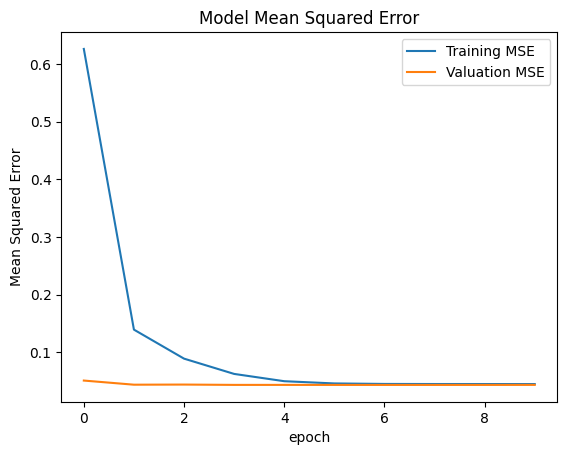

In [12]:
from matplotlib import pyplot as plt

plt.plot(emb_hist.history['mean_squared_error'])
plt.plot(emb_hist.history['val_mean_squared_error'])
plt.title('Model Mean Squared Error')
plt.ylabel('Mean Squared Error')
plt.xlabel('epoch')
plt.legend(['Training MSE', 'Valuation MSE'], loc='upper right')
plt.show()

In [13]:
user_latent_features = emb.get_layer('user_embedding').get_weights()[0]
print(f"User features shape: {user_latent_features.shape}")

item_latent_features = emb.get_layer('item_embedding').get_weights()[0]
print(f"Item features shape: {item_latent_features.shape}")

User features shape: (33901, 16)
Item features shape: (126, 16)


In [14]:
user_latent_df = pd.DataFrame(user_latent_features, columns=[f'User_Feature_{i}' for i in range(user_latent_features.shape[1])])
user_latent_df.insert(0, 'User_ID', list(user_id2idx.keys()))
user_latent_df.head() 

,User_ID,User_Feature_0,User_Feature_1,User_Feature_2,User_Feature_3,User_Feature_4,User_Feature_5,User_Feature_6,User_Feature_7,User_Feature_8,User_Feature_9,User_Feature_10,User_Feature_11,User_Feature_12,User_Feature_13,User_Feature_14,User_Feature_15
0,1889878,0.014808,0.013577,0.006729,-0.018802,-0.007591,-0.000086,-0.000357,-0.000500,0.008117,0.033398,-0.000174,0.005207,-0.013386,-0.003897,0.008208,-0.005040
1,1342067,-0.000046,-0.002442,0.020084,-0.037571,-0.010658,0.000855,-0.028289,0.018258,0.006916,0.021029,0.015664,0.019668,-0.001802,0.008978,-0.003601,-0.013648
2,1990814,-0.000238,-0.013724,-0.010033,-0.008588,-0.008408,-0.016215,-0.015653,0.003461,0.000108,0.003689,-0.014916,0.008365,0.006727,-0.013234,0.015803,-0.020761
3,380098,0.020819,0.000951,0.016264,0.003878,0.010665,-0.003734,-0.001040,0.003037,0.012052,0.006066,0.001822,0.001485,-0.005882,0.017005,0.017154,0.008813
4,779563,0.025685,0.007523,-0.000176,0.004195,-0.008503,-0.013916,-0.003660,0.013068,0.013454,-0.004228,-0.007115,0.005724,0.008734,-0.022533,0.020463,-0.009440


In [15]:
course_latent_df = pd.DataFrame(item_latent_features, columns= [f'Course_Feature_{i}' for i in range(item_latent_features.shape[1])])
course_latent_df.insert(0, 'Course_ID', list(course_id2idx.keys()))
course_latent_df.head()

,Course_ID,Course_Feature_0,Course_Feature_1,Course_Feature_2,Course_Feature_3,Course_Feature_4,Course_Feature_5,Course_Feature_6,Course_Feature_7,Course_Feature_8,Course_Feature_9,Course_Feature_10,Course_Feature_11,Course_Feature_12,Course_Feature_13,Course_Feature_14,Course_Feature_15
0,CC0101EN,-0.039589,0.001454,-0.127808,0.046489,-0.202869,-0.034958,-0.024419,0.259359,-0.029434,-0.049493,0.086222,-0.026346,-0.042388,-0.083758,0.053115,0.185513
1,CL0101EN,0.043504,0.015255,-0.001243,-0.061984,-0.031195,-0.084677,-0.037107,-0.006137,-0.049790,0.017848,0.043435,0.105203,-0.262615,0.171004,-0.104556,-0.063704
2,ML0120ENv3,0.155786,-0.159282,-0.079448,-0.245659,0.161663,-0.028523,0.069906,-0.136039,0.194870,0.115370,0.110074,-0.072616,-0.050089,-0.163412,-0.003889,-0.031120
3,BD0211EN,-0.011968,0.182126,0.266682,-0.043758,-0.043930,0.099372,0.039972,-0.014621,-0.026980,0.207744,-0.012269,0.126701,0.077852,0.136009,0.126544,-0.145018
4,DS0101EN,-0.056184,-0.216244,0.009781,-0.191853,0.003425,-0.039223,-0.156279,-0.140308,0.001392,-0.114632,-0.019614,0.007624,0.007565,-0.046969,-0.012688,0.169446


In [16]:
user_latent_df.to_csv('User_Embeddings.csv', index=False)

In [17]:
course_latent_df.to_csv('Course_Embeddings.csv', index=False)